# Example of openloop gate optimization

### Import and definitions

In [36]:
import numpy as np
import tensorflow as tf
from scipy.linalg import expm

In [37]:
import c3po.control as control
import c3po.component as component
import c3po.generator as generator
import c3po.envelopes as envelopes
import c3po.hamiltonians as hamiltonians

In [38]:
from c3po.model import Model as Mdl
from c3po.simulator import Simulator as Sim
from c3po.optimizer import Optimizer as Opt
from c3po.experiment import Experiment as Exp

In [39]:
from c3po.utils import log_setup
from c3po.tf_utils import tf_limit_gpu_memory, tf_abs, tf_ave, tf_kron
from c3po.qt_utils import basis, xy_basis, perfect_gate

### Specify parameters of the system

In [40]:
# System
qubit_freq1 = 5.805e9 * 2 * np.pi
qubit_anhar1 = -0.217e9 * 2 * np.pi 
# here  a negative anharmonicity gives a smaller spacing of 1-2 than 0-1
# from the email this should be positive but we're assuming it was a type (in case it's not fell free to change it)
qubit_freq2 = 5.238e9 * 2 * np.pi
qubit_anhar2 = -0.226e9 * 2 * np.pi
g_coupling = 4.22e9 * 2 * np.pi
qubit_lvls = 4

coupling_ham = hamiltonians.int_YY
drive_ham = hamiltonians.y_drive
v_hz_conversion = 1 # this allows you to put voltage as amplitude and it will convert them to Hz
t_final = 5e-9 # length of the gates

env_freq = 0.5 / t_final * 2 * np.pi
carr_freq = qubit_freq1

In [41]:
# Resolutions
sim_res = 250e9
awg_res = 250e9 # this high resolution is needed to simulate the high frequency components in the drive 

In [42]:
# Directory to log into
logdir = log_setup("/tmp/c3logs/")

### Create model object that contains information on the Hamiltonians

In [43]:
q1 = component.Qubit(
    name="Q1",
    desc="Qubit 1",
    comment="the higher frequency qubit",
    freq=qubit_freq1,
    anhar=qubit_anhar1,
    hilbert_dim=qubit_lvls
)
drive = component.Drive(
    name="D1",
    desc="Drive line 1, driving both qubits",
    connected=["Q1"],
    hamiltonian=drive_ham
)

chip_elements = [q1, drive]
model = Mdl(chip_elements)

### Create generator object that contains information of the control lines

In [44]:
# Takes parameters and get AWG bin values
awg = generator.AWG(resolution=awg_res, logdir=logdir)
# Reshapes the signal from the AWG samples to the simulation resolution
dig_to_an = generator.Digital_to_Analog(resolution=sim_res)
# Creates the LO signal
lo = generator.LO(resolution=sim_res)
# Mixes LO and AWG signals
mixer = generator.Mixer()
# Transforms signal from a given voltage on the device to Hz (that go in front of the Hamiltonian)
v_to_hz = generator.Volts_to_Hertz(V_to_Hz=v_hz_conversion)

In [45]:
# Pass all of these devices to the generator object that uses them to make signal from parameters
devices = [lo, awg, mixer, v_to_hz, dig_to_an]
gen = generator.Generator(devices)

### Create gates/operations to implement

In [46]:
# Define parameters and bounds of given envelope functions
fsin_params = {
    'amp': 0.5 * np.pi / t_final, # power in Volts (rescaled with v_hz_conversion)
    'amps': 1 / np.arange(1, 10, 2), # relative amplitude of each component
    # you can also just adjust the amps in volts directly and not include amp (it will default to 1)
    'freqs': np.arange(1, 10, 2) * env_freq,
    'xy_angle': 0.0, # this angle makes this envelope mix with the cos of the carrier
}
fsin_bounds = {
    'amp': [0.0, np.pi / t_final],
    'amps': [0.0, 2.0] * 5,
    'freqs': np.arange(0.5, 10, 1) * env_freq,
    'xy_angle': [-np.pi/4, np.pi/4]
}
# Create envelope object, the function is taken from our library in envelopes.py
fsin = control.Envelope(
    name="I_fsin",
    desc="Inphase envelope with 5 sin components",
    params=fsin_params,
    bounds=fsin_bounds,
    shape=envelopes.fourier_sin
)

In [47]:
# Define parameters and bounds of given envelope functions
fcos_params = {
    'amp': 0.25 * np.pi / t_final,
    'amps': np.zeros(5),
    'freqs': np.arange(1, 10, 2) * env_freq,
    'xy_angle': np.pi/2, # this angle makes this envelope mix with the sin of the carrier
}
fcos_bounds = {
    'amp': [0.0, 0.5 * np.pi / t_final],
    'amps': [-1.0, 1.0] * 5,
    'freqs': np.arange(0.5, 10, 1) * env_freq,
    'xy_angle': [np.pi/4, 3*np.pi/4]
}
# Create envelope object, the function is taken from our library in envelopes.py
fcos = control.Envelope(
    name="Q_fcos",
    desc="Quadrature envelope with 5 cos components",
    params=fcos_params,
    bounds=fcos_bounds,
    shape=envelopes.fourier_cos
)

In [48]:
# Define parameters and bounds of the carrier (this will be used by the LO)
carrier_params = {
    'freq': carr_freq
}
carrier_bounds = {
    'freq': [4e9 * 2 * np.pi, 7e9 * 2 * np.pi]
}
# Create carrier object
carr = control.Carrier(
    name="carrier1",
    desc="Frequency of the local oscillator 1",
    params=carrier_params,
    bounds=carrier_bounds
)

In [49]:
# Create Gate/operation and pass envelopes and carrier

### Single qubit rotation for qubit 1
Y90p_Q1 = control.Instruction(
    name="Y90p_Q1",
    desc="pi/2 rotation around Y for qubit1",
    t_start=0.0,
    t_end=t_final,
    channels=["D1"]
)
Y90p_Q1.add_component(fsin, "D1")
Y90p_Q1.add_component(fcos, "D1")
Y90p_Q1.add_component(carr, "D1")

In [50]:
# Create gateset object and pass the gate created
gates = control.GateSet()
gates.add_instruction(Y90p_Q1)

### Create experiment class and simulator (this is where the computation of the unitary is done)

In [51]:
# Simulation class and fidelity function
exp = Exp(model, gen)
sim = Sim(exp, gates)

In [52]:
# Introduce a Z rotation of the unitary after the gate to rotate back into the qubit frame
a_q1 = model.ann_opers[model.names.index('Q1')]
sim.VZ = expm(1.0j * np.matmul(a_q1.T.conj(), a_q1) * qubit_freq1 * t_final)

### Create optimizer object

In [53]:
# Optimizer object
opt = Opt(data_path=logdir)

In [54]:
# Define the map of which parameters will be optimized. The rest will be fixed
opt_map = [
#     [('Y90p_Q1', 'D1', 'I_fsin', 'amp')],
#     [('Y90p_Q1', 'D1', 'Q_fcos', 'amp')],
     [('Y90p_Q1', 'D1', 'I_fsin', 'amps')],
     [('Y90p_Q1', 'D1', 'Q_fcos', 'amps')],
]
# in this case we will only optimize the X90p operation on Q1

In [55]:
# Define states & unitaries
ket_0 = tf.constant(basis(qubit_lvls, 0), dtype=tf.complex128)
bra_0 = tf.constant(basis(qubit_lvls, 0).T, dtype=tf.complex128)
bra_xm = tf.constant(xy_basis(qubit_lvls, 'xm').T, dtype=tf.complex128)
ket_00 = tf_kron(ket_0, ket_0)
bra_xm0 = tf_kron(bra_xm, bra_0)
Y90p_ideal = tf.constant(perfect_gate(qubit_lvls, 'Y90p', proj=True), dtype=tf.complex128)
Id = tf.constant(perfect_gate(qubit_lvls, 'Id'), dtype=tf.complex128)
Y90p_Q1_ideal = tf_kron(Y90p_ideal, Id)

In [56]:
def unitary_infid(U_dict: dict):
    U = U_dict['Y90p_Q1']
    unit_fid = tf_abs(
                tf.linalg.trace(
                    tf.matmul(U, tf.linalg.adjoint(Y90p_ideal))
                    ) / 2
                )**2
    infid = 1 - unit_fid
    return infid

In [57]:
with tf.device('/CPU:0'):
    opt.optimize_controls(
        sim=sim,
        opt_map=opt_map,
        opt='lbfgs',
        opt_name='openloop',
        fid_func=unitary_infid
    )

Saving as:
/tmp/c3logs/2019_11_22_T_14_17_54/openloop.log


In [ ]:
gates.instructions['Y90p_Q1'].comps['D1']['I_fsin'].params

In [ ]:
gates.instructions['Y90p_Q1'].comps['D1']['Q_fcos'].params

In [31]:
#Check unitary
params, _ = gates.get_parameters(opt_map)
U_dict = sim.get_gates(params, opt_map)
U_dict['Y90p_Q1']

<tf.Tensor: id=436314, shape=(4, 4), dtype=complex128, numpy=
array([[ 0.72747577+0.01534741j, -0.67471192+0.06037841j,
        -0.00929963+0.10731073j,  0.0070862 +0.00307224j],
       [ 0.67471345-0.06043168j,  0.71961464-0.13504934j,
        -0.06439322+0.02928488j,  0.00365696+0.00295813j],
       [-0.0092987 +0.10727171j,  0.0644187 -0.02937441j,
         0.82697761+0.54406786j, -0.02433038-0.05385083j],
       [-0.00707876-0.00307057j,  0.0036582 +0.00295178j,
         0.02444763+0.05379904j, -0.15371666+0.98630499j]])>

In [62]:
# check if projected unitary fidelity and not projected are at least close
Y90p_ideal = tf.constant(perfect_gate(qubit_lvls, 'Y90p', proj=False), dtype=tf.complex128)
U = U_dict['Y90p_Q1']
unit_fid = tf_abs(
            tf.linalg.trace(
                tf.matmul(U, tf.linalg.adjoint(Y90p_ideal))
                ) / qubit_lvls
            )**2
infid = 1 - unit_fid
infid

<tf.Tensor: id=5901969, shape=(1,), dtype=float64, numpy=array([0.44521121])>

In [65]:
import qutip as qt

In [91]:
U

<tf.Tensor: id=436314, shape=(4, 4), dtype=complex128, numpy=
array([[ 0.72747577+0.01534741j, -0.67471192+0.06037841j,
        -0.00929963+0.10731073j,  0.0070862 +0.00307224j],
       [ 0.67471345-0.06043168j,  0.71961464-0.13504934j,
        -0.06439322+0.02928488j,  0.00365696+0.00295813j],
       [-0.0092987 +0.10727171j,  0.0644187 -0.02937441j,
         0.82697761+0.54406786j, -0.02433038-0.05385083j],
       [-0.00707876-0.00307057j,  0.0036582 +0.00295178j,
         0.02444763+0.05379904j, -0.15371666+0.98630499j]])>

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efabc22a760>)

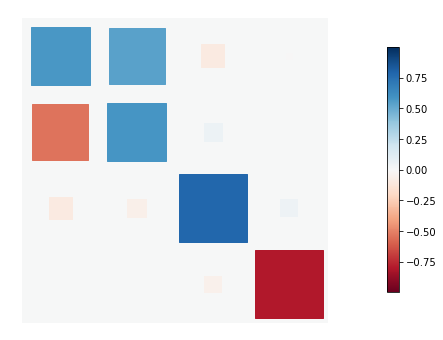

In [68]:
qt.hinton(U.numpy())

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efa50552040>)

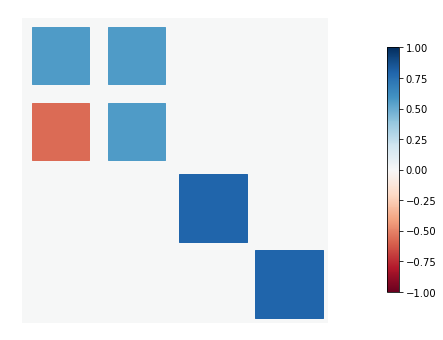

In [71]:
Y90p_ideal = tf.constant(perfect_gate(qubit_lvls, 'Y90p', proj=False), dtype=tf.complex128)
qt.hinton(Y90p_ideal.numpy())

array([[ 1.00000000e+00+9.52526357e-19j,  6.45404412e-16-7.30851389e-16j,
        -1.09526125e-15+5.11685642e-17j, -1.40982109e-16+2.02828108e-16j],
       [ 6.45404412e-16+7.28775916e-16j,  1.00000000e+00-1.52949692e-18j,
        -3.87654864e-16+5.84555571e-15j,  7.82508532e-16+6.37587147e-16j],
       [-1.09526125e-15-4.70774942e-17j, -3.87654864e-16-5.83897038e-15j,
         1.00000000e+00-1.57615047e-17j,  3.65674574e-15-1.28670929e-14j],
       [-1.40982109e-16-2.03456911e-16j,  7.82508532e-16-6.37681934e-16j,
         3.65674574e-15+1.28721778e-14j,  1.00000000e+00-1.00432216e-17j]])

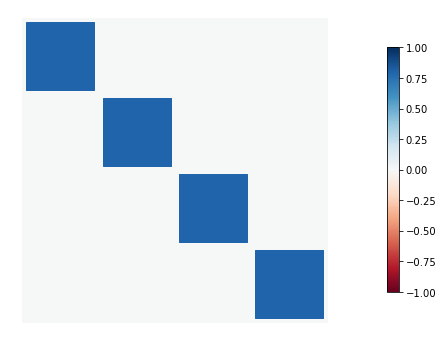

In [90]:
qt.hinton((tf.linalg.adjoint(U)@U).numpy())
(tf.linalg.adjoint(U)@U).numpy()

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efa50332220>)

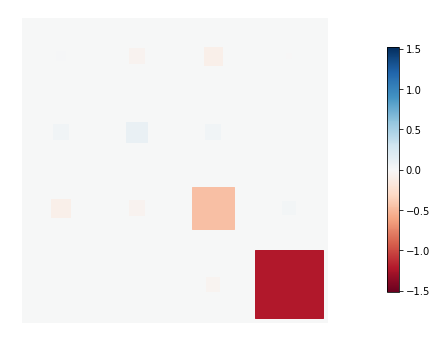

In [72]:
qt.hinton((U-Y90p_ideal).numpy())

In [63]:
U

<tf.Tensor: id=436314, shape=(4, 4), dtype=complex128, numpy=
array([[ 0.72747577+0.01534741j, -0.67471192+0.06037841j,
        -0.00929963+0.10731073j,  0.0070862 +0.00307224j],
       [ 0.67471345-0.06043168j,  0.71961464-0.13504934j,
        -0.06439322+0.02928488j,  0.00365696+0.00295813j],
       [-0.0092987 +0.10727171j,  0.0644187 -0.02937441j,
         0.82697761+0.54406786j, -0.02433038-0.05385083j],
       [-0.00707876-0.00307057j,  0.0036582 +0.00295178j,
         0.02444763+0.05379904j, -0.15371666+0.98630499j]])>

In [86]:
X90p = tf.constant(perfect_gate(2, 'X90p', proj=False), dtype=tf.complex128)

In [87]:
X90p

<tf.Tensor: id=5903179, shape=(2, 2), dtype=complex128, numpy=
array([[0.70710678+0.j        , 0.        -0.70710678j],
       [0.        -0.70710678j, 0.70710678+0.j        ]])>

In [89]:
X90p.numpy().T.conj()@X90p.numpy()

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [81]:
tf.linalg.adjoint(Y90p)

<tf.Tensor: id=5903178, shape=(2, 2), dtype=complex128, numpy=
array([[ 0.70710678-0.j,  0.70710678-0.j],
       [-0.70710678-0.j,  0.70710678-0.j]])>

# Plotting

You can run the code below in a different kernel to get a live plot. Or look a the log e.g.

$ less +F /tmp/c3logs/recent/openloop.log

In [ ]:
from c3po.display import plot_OC_logs
plot_OC_logs("/tmp/c3logs/recent/openloop.log")